# McDonald's sentiment data

## Problem statement

McDonald's receives **thousands of customer comments** on their website per day, and many of them are negative. Their corporate employees don't have time to read every single comment, but they do want to read a subset of comments that they are most interested in. In particular, the media has recently portrayed their employees as being rude, and so they want to review comments about **rude service**.

McDonald’s is looking to  develop a system that ranks each comment by the **likelihood that it is referring to rude service**. They will need a "rudeness dashboard" for their corporate employees, so that employees can spend a few minutes each day examining the **most relevant recent comments**.

## Description of the data

The dataset is sourced from http://www.crowdflower.com/data-for-everyone). It has about 1500 comments with the **type of complaint**. The complaint types are listed below, with the encoding used in the data listed in parentheses:

- Bad Food (BadFood)
- Bad Neighborhood (ScaryMcDs)
- Cost (Cost)
- Dirty Location (Filthy)
- Missing Item (MissingFood)
- Problem with Order (OrderProblem)
- Rude Service (RudeService)
- Slow Service (SlowService)
- None of the above (na)

## Task 1: Get the data

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
import warnings
import unidecode
import pickle
from keras.preprocessing.sequence import pad_sequences # for padding
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint # to prevent overfitting and save the best model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# read mcdonalds.csv using a relative path
mac = pd.read_csv('data/mcdonalds.csv',encoding='latin-1')
mac.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,policies_violated,policies_violated:confidence,city,policies_violated_gold,review
0,679455653,False,finalized,3,2/21/15 0:36,RudeService\r\nOrderProblem\r\nFilthy,1.0\r\n0.6667\r\n0.6667,Atlanta,NaN,"I'm not a huge mcds lover, but I've been to be..."
1,679455654,False,finalized,3,2/21/15 0:27,RudeService,1,Atlanta,NaN,Terrible customer service. I came in at 9:30pm...
2,679455655,False,finalized,3,2/21/15 0:26,SlowService\r\nOrderProblem,1.0\r\n1.0,Atlanta,NaN,"First they ""lost"" my order, actually they gave..."


## Task 2: Inspect and clean the data


In [3]:
mac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 10 columns):
_unit_id                        1528 non-null int64
_golden                         1528 non-null bool
_unit_state                     1528 non-null object
_trusted_judgments              1528 non-null int64
_last_judgment_at               1528 non-null object
policies_violated               1474 non-null object
policies_violated:confidence    1474 non-null object
city                            1441 non-null object
policies_violated_gold          0 non-null float64
review                          1528 non-null object
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 109.0+ KB


In [4]:
# examine the shape before removing any rows
mac.shape

(1528, 10)

In [5]:
# count the number of null values in each column
mac.isnull().sum()

_unit_id                           0
_golden                            0
_unit_state                        0
_trusted_judgments                 0
_last_judgment_at                  0
policies_violated                 54
policies_violated:confidence      54
city                              87
policies_violated_gold          1528
review                             0
dtype: int64

In [6]:
# examine the text of the first review
mac.loc[0, 'review']

"I'm not a huge mcds lover, but I've been to better ones. This is by far the worst one I've ever been too! It's filthy inside and if you get drive through they completely screw up your order every time! The staff is terribly unfriendly and nobody seems to care."

In [7]:
# filter the DataFrame to only include rows in which policies_violated is not null
mac.dropna(subset = ['policies_violated'], inplace=True)

In [8]:
# examine the shape after removing rows
mac.shape

(1474, 10)

## Task 3: Exploratory Data Analysis

**Create a response variable for "rude".** Also, create columns for **other violations**. These respective columns will have the value 1 if that violation was recorded for that review, and 0 if that wasn't the violation for that review.

In [9]:
# record the violation 'RudeService'
mac['rude'] = mac.policies_violated.str.contains('RudeService').astype(int)

In [10]:
# record other violations
mac['BadFood'] = mac.policies_violated.str.contains('BadFood').astype(int)
mac['ScaryMcDs'] = mac.policies_violated.str.contains('ScaryMcDs').astype(int)
mac['Cost'] = mac.policies_violated.str.contains('Cost').astype(int)
mac['Filthy'] = mac.policies_violated.str.contains('Filthy').astype(int)
mac['MissingFood'] = mac.policies_violated.str.contains('MissingFood').astype(int)
mac['OrderProblem'] = mac.policies_violated.str.contains('OrderProblem').astype(int)
mac['SlowService'] = mac.policies_violated.str.contains('SlowService').astype(int)
mac['na'] = mac.policies_violated.str.contains('na').astype(int)

In [11]:
# Count of the total violations at McDonalds
list_of_violations = ['rude','BadFood','ScaryMcDs','Cost','Filthy','MissingFood','OrderProblem','SlowService','na']
mac.sum()[list_of_violations].sort_values(ascending=False)

rude            509
SlowService     361
OrderProblem    336
na              307
BadFood         260
ScaryMcDs       134
Filthy          130
MissingFood      54
Cost             54
dtype: object

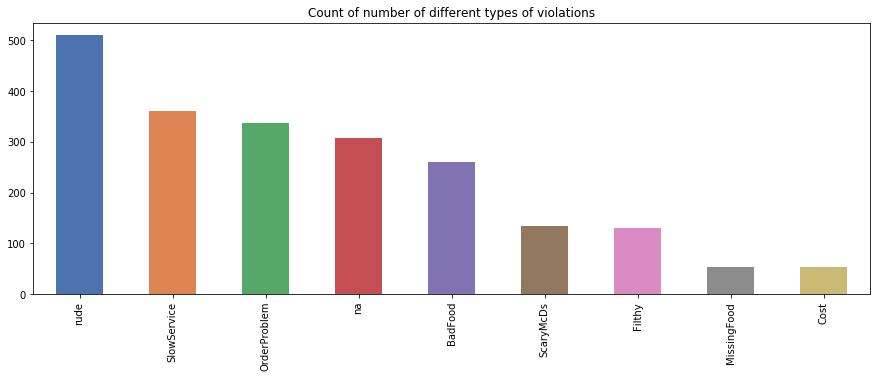

In [12]:
# Plot a histogram of all the violations
mac.sum()[list_of_violations] \
    .sort_values(ascending=False) \
    .head(10) \
    .plot(kind='bar', figsize=(15, 5),
          color=sns.color_palette("deep", 10),
          title='Count of number of different types of violations')
plt.show()

In [13]:
# Count of the violations at the various cities outlets of McDonalds
mac.groupby('city').sum()[list_of_violations]

,rude,BadFood,ScaryMcDs,Cost,Filthy,MissingFood,OrderProblem,SlowService,na
city,,,,,,,,,
Atlanta,44,26,7,3,15,5,28,37,25
Chicago,64,27,30,8,15,5,50,49,48
Cleveland,29,3,1,3,5,6,20,27,9
Dallas,24,14,10,5,7,3,18,14,14
Houston,37,24,2,3,16,4,20,29,26
Las Vegas,142,78,21,15,30,13,100,88,78
Los Angeles,47,18,27,5,9,7,40,47,30
New York,61,34,22,6,19,6,19,35,37
Portland,30,26,8,6,8,1,21,11,24


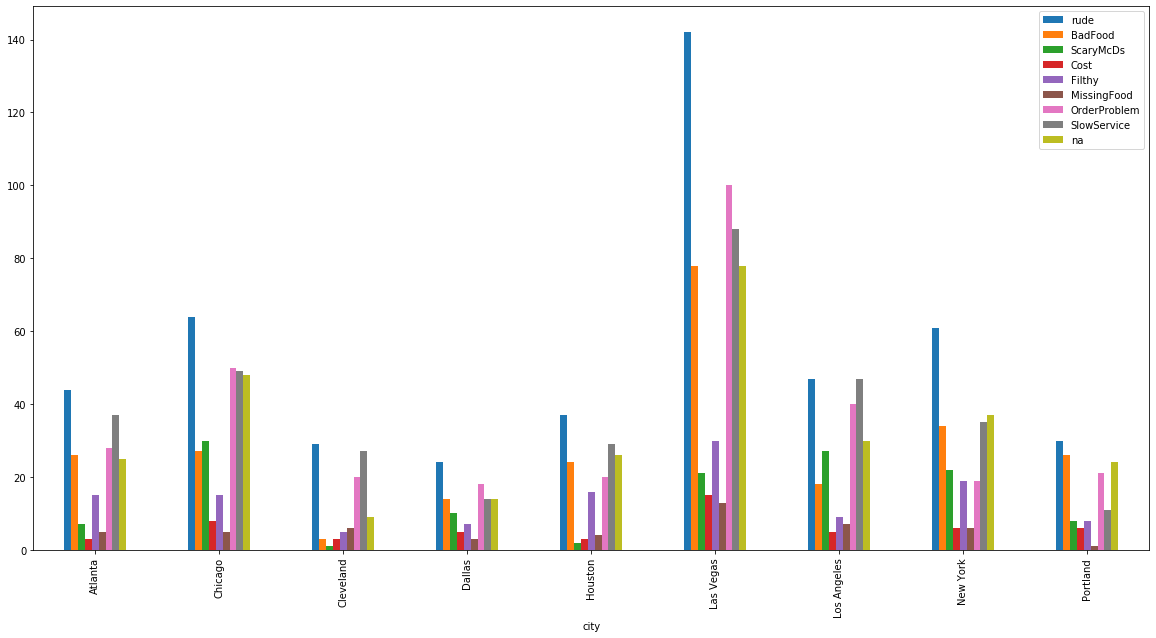

In [14]:
# Plot a histogram of all the violations at the various cities outlets of McDonalds
_ = mac.groupby('city').sum()[list_of_violations].plot.bar(figsize=(20,10))

## Task 4: Create a language detection model 
    (to identify what languages the reviews in the dataset are from)
#### We're only interested in translating Spanish reviews as our language model is trained only for Spa to Eng translations


In [15]:
from langdetect import detect 
def translate(review):
    return detect(review)

mac['lang'] = mac['review'].apply(translate)

In [16]:
# transfer all the spanish ('es') rows over to another df, so that it can be used to translate to English sentences
df_spa_df = mac.loc[mac['lang'] == 'es',['review','lang']]

In [17]:
# Check 
mac.lang.value_counts()

en    1467
es       7
Name: lang, dtype: int64

In [18]:
df_spa_df.shape

(7, 2)

In [19]:
df_spa_df.columns

Index(['review', 'lang'], dtype='object')

In [20]:
df_spa_df

,review,lang
3,"Ciertamente, mi peor experiencia ¡Siempre son ...",es
4,Servicio horrible!,es
5,Servicio extremadamente horrible,es
6,Fue asqueroso.,es
7,"servicio patético, comida asquerosa y errores ...",es
8,Pésimo servicio! Experiencia decepcionante,es
9,asqueroso y molesto,es


## Task 5: Translate Spa reviews to English 
### Task 5: 1. Preprocess test

In [21]:
import unidecode
import re
# function to preprocess the text
def cleaner(text):
    newString = text.lower()
    unaccented_string = unidecode.unidecode(newString)
    newString = re.sub("'",'', unaccented_string) 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = newString.split()
    return (" ".join(tokens)).strip()

In [22]:
df_spa_df['cleaned_mac_spa_reviews'] = df_spa_df['review'].apply(cleaner)
df_spa_df

,review,lang,cleaned_mac_spa_reviews
3,"Ciertamente, mi peor experiencia ¡Siempre son ...",es,ciertamente mi peor experiencia siempre son ex...
4,Servicio horrible!,es,servicio horrible
5,Servicio extremadamente horrible,es,servicio extremadamente horrible
6,Fue asqueroso.,es,fue asqueroso
7,"servicio patético, comida asquerosa y errores ...",es,servicio patetico comida asquerosa y errores p...
8,Pésimo servicio! Experiencia decepcionante,es,pesimo servicio experiencia decepcionante
9,asqueroso y molesto,es,asqueroso y molesto


In [23]:
# load the saved model and save its weights
model = load_model('pickle_and_trained_models/best_model_v4.h5')
model.load_weights('pickle_and_trained_models/best_model_weights_v4.h5')
encoder_model = load_model('pickle_and_trained_models/encoder_model.h5')
decoder_model = load_model('pickle_and_trained_models/docoder_model.h5')



W0918 20:56:37.737320 78856 deprecation_wrapper.py:119] From C:\Users\seqpr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 20:56:37.758692 78856 deprecation_wrapper.py:119] From C:\Users\seqpr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 20:56:37.761101 78856 deprecation_wrapper.py:119] From C:\Users\seqpr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 20:56:38.336514 78856 deprecation_wrapper.py:119] From C:\Users\seqpr\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0918 20:56:38.338487 78856 deprecation_wrapper.py:119] 

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 200)      2633600     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 16, 200)      1616200     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LS

In [25]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 200)           2633600   
_________________________________________________________________
lstm_1 (LSTM)                [(None, 15, 150), (None,  210600    
Total params: 2,844,200
Trainable params: 2,844,200
Non-trainable params: 0
_________________________________________________________________


In [26]:
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    1616200     input_5[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
lstm_2 (LS

In [27]:
# To be able to translate Spa to Eng, we need to use the same word_index as the trained translation model
# translation model was created in another notebook using the 'eng-spa' translations dataset

with open('pickle_and_trained_models/source_word_freq.pickle', 'rb') as handle:
    source_word_freq = pickle.load(handle)
    
with open('pickle_and_trained_models/source_word_index.pickle', 'rb') as handle:
    source_word_index = pickle.load(handle)
    
with open('pickle_and_trained_models/target_word_index.pickle', 'rb') as handle:
    target_word_index = pickle.load(handle)

In [28]:
print(df_spa_df.columns)
print(len(source_word_freq))
print(source_word_index['estadounidenses'])
print(len(source_word_index))

Index(['review', 'lang', 'cleaned_mac_spa_reviews'], dtype='object')
22940
4371
13168


### Task 5: 2. Create integer-sequences from the Spanish sentences.

In [29]:
# set threshold value for rare words
thresh=2

source_vocab=[key for key,value in source_word_index.items()]  #spanish vocabulary

# sentences to integer sequences (Spanish sentences - training data)
source_seq_tr=[]
for i in df_spa_df['cleaned_mac_spa_reviews']:
#for i in df_spa['cleaned_spa']:    
  seq=[]
  for j in i.split():
    if(j not in source_vocab):
      seq.append(source_word_index['<unk>'])
    elif(source_word_freq[j]<thresh):
      seq.append(source_word_index['<unk>'])
    else:
      seq.append(source_word_index[j])
  source_seq_tr.append(seq)

In [30]:
source_seq_tr[:10]

[[7377, 343, 387, 513, 88, 354, 3258, 3217],
 [2675, 4001],
 [2675, 3258, 4001],
 [70, 9052],
 [2675, 8468, 885, 1, 8, 416, 2197],
 [518, 2675, 513, 5353],
 [9052, 8, 6990]]

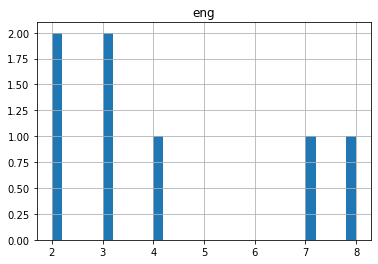

In [31]:
# check sentence length
import matplotlib.pyplot as plt

eng_word_count = []
spa_word_count = []

# populate the lists with sentence lengths
for i in df_spa_df['cleaned_mac_spa_reviews']:
      eng_word_count.append(len(i.split()))



length_df = pd.DataFrame({'eng':eng_word_count})
length_df.hist(bins = 30)
plt.show()

In [32]:
# set maximum length for English and Spanish sentences
max_eng_len=15
max_spa_len=15

In [33]:
# pad Spanish sequences
from keras.preprocessing.sequence import pad_sequences # for padding

x_tr = pad_sequences(source_seq_tr,  maxlen=max_spa_len, padding='post', truncating='post')
x_voc = len(source_vocab)

In [34]:
# swap dictionary pairs
reverse_target_word_index=dict((v, k) for k, v in target_word_index.items())
reverse_source_word_index=dict((v, k) for k, v in source_word_index.items())
print(len(reverse_target_word_index))
print(len(reverse_source_word_index))

8081
13168


### Task 5: 3. Translate a few sentences

In [35]:
# take a sample from the validation data
unclean_spa_text = df_spa_df['review'].tolist()
source = df_spa_df['cleaned_mac_spa_reviews'].tolist()
print(unclean_spa_text)


['Ciertamente, mi peor experiencia ¡Siempre son EXTREMADAMENTE lentos!', 'Servicio horrible!', 'Servicio extremadamente horrible', 'Fue asqueroso.', 'servicio patético, comida asquerosa y errores peligrosos', 'Pésimo servicio! Experiencia decepcionante', 'asqueroso y molesto']


In [36]:
print(source)

['ciertamente mi peor experiencia siempre son extremadamente lentos', 'servicio horrible', 'servicio extremadamente horrible', 'fue asqueroso', 'servicio patetico comida asquerosa y errores peligrosos', 'pesimo servicio experiencia decepcionante', 'asqueroso y molesto']


In [37]:
x_tr

array([[7377,  343,  387,  513,   88,  354, 3258, 3217,    0,    0,    0,
           0,    0,    0,    0],
       [2675, 4001,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [2675, 3258, 4001,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [  70, 9052,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [2675, 8468,  885,    1,    8,  416, 2197,    0,    0,    0,    0,
           0,    0,    0,    0],
       [ 518, 2675,  513, 5353,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [9052,    8, 6990,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<end>'):
            decoded_sentence= decoded_sentence+sampled_token+' '

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<end>'  or len(decoded_sentence.split()) >= (max_eng_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

In [39]:
predicted=[]
for i in x_tr:
    predicted.append(decode_sequence(i.reshape(1,max_spa_len)))
# add the actual and the predicted sentences to a dataframe
df_mac = pd.DataFrame({"Unclean_spa": unclean_spa_text, "Source": source,"predicted":predicted})
df_mac

,Unclean_spa,Source,predicted
0,"Ciertamente, mi peor experiencia ¡Siempre son ...",ciertamente mi peor experiencia siempre son ex...,my worst ideas is always worth making sense
1,Servicio horrible!,servicio horrible,awful service
2,Servicio extremadamente horrible,servicio extremadamente horrible,extremely horrible service
3,Fue asqueroso.,fue asqueroso,it was disgusting
4,"servicio patético, comida asquerosa y errores ...",servicio patetico comida asquerosa y errores p...,hands <unk> food for food than food dont seem ...
5,Pésimo servicio! Experiencia decepcionante,pesimo servicio experiencia decepcionante,terrible amazing experience
6,asqueroso y molesto,asqueroso y molesto,im confused and things


### Task 5: 4. Update the 'Spa' review with the predicted 'Eng' text (so that we can use it for classification of all Eng reviews)

In [40]:
# Shows all the spanish ('es') reviews
mac[mac['lang'] == 'es']['review']

3    Ciertamente, mi peor experiencia ¡Siempre son ...
4                                   Servicio horrible!
5                     Servicio extremadamente horrible
6                                       Fue asqueroso.
7    servicio patético, comida asquerosa y errores ...
8           Pésimo servicio! Experiencia decepcionante
9                                  asqueroso y molesto
Name: review, dtype: object

In [41]:
# Function that takes in a spanish ('es') review AND returns the translated English review
def translate_to_eng(spa_txt):
    my_str = df_mac[df_mac['Unclean_spa'] == spa_txt]['predicted'].values
    return my_str[0]

In [42]:
# Check if the translation works
mac[mac['lang'] == 'es']['review'].apply(translate_to_eng)

3          my worst ideas is always worth making sense
4                                        awful service
5                           extremely horrible service
6                                    it was disgusting
7    hands <unk> food for food than food dont seem ...
8                          terrible amazing experience
9                               im confused and things
Name: review, dtype: object

In [43]:
# Assign the Spa to Eng translation 
mac.loc[mac['lang'] == 'es',['review']] = mac[mac['lang'] == 'es']['review'].apply(translate_to_eng)

In [44]:
# Check if the spanish review have changed to English
mac[mac['lang'] == 'es']['review']

3          my worst ideas is always worth making sense
4                                        awful service
5                           extremely horrible service
6                                    it was disgusting
7    hands <unk> food for food than food dont seem ...
8                          terrible amazing experience
9                               im confused and things
Name: review, dtype: object

In [45]:
mac.loc[mac['lang'] == 'es',['lang']] = 'en'

In [46]:
mac.lang.value_counts()

en    1474
Name: lang, dtype: int64

In [47]:
# Save mac dataframe which has now translated reviews, so that we can use it in 2_Classification_Model_Mac_with_DL.ipynb, 
# to check if Deep Learning can give use better accuracy
with open('pickle_and_trained_models/mac.pickle', 'wb') as handle:
    pickle.dump(mac, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Task 6:

1. Define X (the **review** column) and y (the **rude** column).
2. Split X and y into training and testing sets.
3. Use CountVectorizer (with the **default parameters**) to create document-term matrices from X_train and X_test.

In [48]:
# define X and y
X = mac.review
y = mac.rude

In [49]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [50]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1105,)
(1105,)
(369,)
(369,)


In [51]:
# Get top n words in the corpus with the vectoriser passed in
def get_top_n_words(vec,corpus, n=None):
    
    vec = vec.fit(corpus)
    bag_of_words = vec.transform(corpus)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

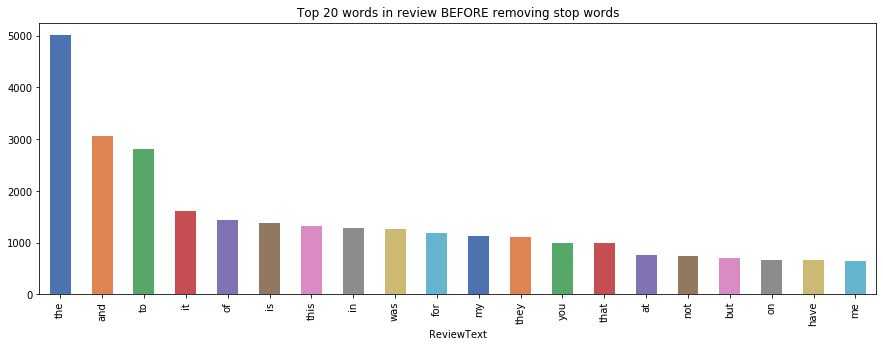

In [52]:
# The distribution of top unigrams BEFORE removing stop words
vect = CountVectorizer()
common_words = get_top_n_words(vect,X_train, 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
_ = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)\
   .plot(kind='bar', figsize=(15, 5),
          color=sns.color_palette("deep", 10),
          title='Top 20 words in review BEFORE removing stop words')

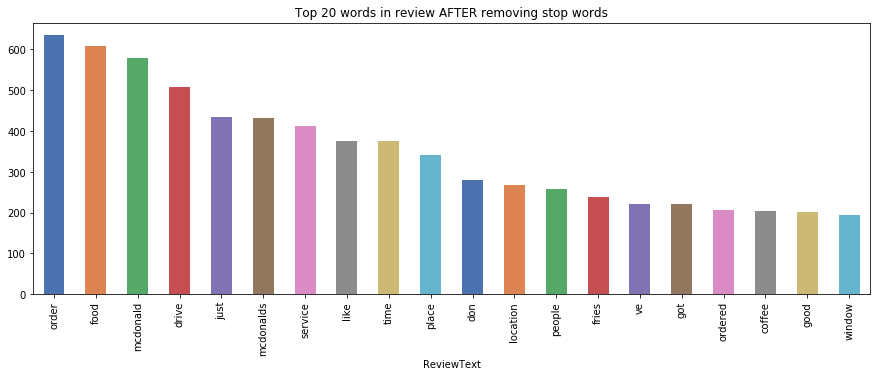

In [53]:
# The distribution of top unigrams AFTER removing stop words

vect = CountVectorizer(stop_words='english')
common_words = get_top_n_words(vect,X_train, 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
_ = df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False)\
   .plot(kind='bar', figsize=(15, 5),
          color=sns.color_palette("deep", 10),
          title='Top 20 words in review AFTER removing stop words')

In [54]:
# Instantiate CountVectorizer

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
X_train_dtm.shape

(1105, 6969)

## Task 7

Try fitting a Multinomial Naive Bayes model to the training set, calculate the **predicted probabilites** (not the class predictions) for the testing set, and then calculate the **AUC**. Also, try using **logistic regression model** to see if it achieves a better AUC.

In [55]:
# import/instantiate/fit a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
# calculate the predicted probability of rude=1 for each testing set observation
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

In [57]:
y_pred_prob[0:5]

array([1.81178898e-03, 6.27592499e-02, 5.74648526e-04, 2.09391038e-07,
       3.02961810e-01])

In [58]:
# calculate the AUC
from sklearn import metrics
metrics.roc_auc_score(y_test, y_pred_prob)

0.83452023988006

In [59]:
# repeat this task using a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_dtm,y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:,1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.8189655172413792

## Task 8

Continue using Naive Bayes as it gave a better AUC in the previous step. Try **tuning CountVectorizer** and check the testing set **AUC** after each change, and find the set of parameters that increases AUC the most.

In [60]:
# define a function that accepts a vectorizer and calculates the AUC
def tokenize_test(vect):
    
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    
    # print the number of features that were generated
    print('Features:', X_train_dtm.shape[1])
    
    # use Multinomial Naive Bayes to calculate predicted probabilities
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
    
    # print the AUC
    print('AUC:', metrics.roc_auc_score(y_test, y_pred_prob))

In [61]:
# confirm that the AUC is identical to task 5 when using the default parameters
vect = CountVectorizer()
tokenize_test(vect)

Features: 6969
AUC: 0.83452023988006


In [62]:
# tune CountVectorizer to increase the AUC
vect = CountVectorizer(stop_words='english', max_df=0.3, min_df=4)
tokenize_test(vect)

Features: 1686
AUC: 0.8267343600926809


## Task 9 

Check if the **city** column might be predictive of the response, and by including it, increases the AUC by adding it to the model.

In [63]:
# widen the column display
pd.set_option('display.max_colwidth', 1000)

In [64]:
# Check which cities have more "rude" violations
mac.groupby('city').rude.sum().sort_values(ascending=False)

city
Las Vegas      142
Chicago         64
New York        61
Los Angeles     47
Atlanta         44
Houston         37
Portland        30
Cleveland       29
Dallas          24
Name: rude, dtype: int32

In [65]:
# concatenate review and city, separated by a space, replacing nulls with 'na'
mac['review_city'] = mac.review.str.cat(mac.city, sep=' ', na_rep='na')

In [66]:
# redefine X and y
X = mac.review_city
y = mac.rude

In [67]:
# re-split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [68]:
# check whether it increased or decreased the AUC of my best model - It has decreases a bit (nothing too significant but)
vect = CountVectorizer(stop_words='english',max_df=0.3, min_df=3)
tokenize_test(vect)

Features: 2153
AUC: 0.8297328608423061


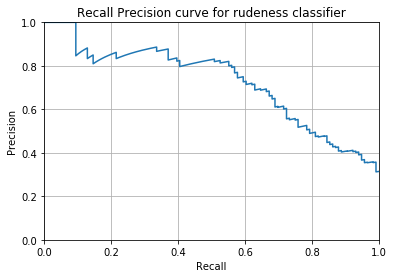

In [69]:
# Plotting the Recall Precision curve
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall,precision)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('Recall Precision curve for rudeness classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

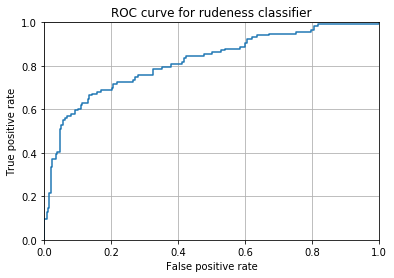

In [70]:
# Plotting the ROC curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC curve for rudeness classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)

## Task 10: Use the entire training dataset and test it on testing dataset

In [71]:
# define X and y using the data that produced the best AUC above
X = mac.review_city
y = mac.rude

In [72]:
# instantiate CountVectorizer with the tuning parameters that produced the best AUC above
vect = CountVectorizer(stop_words='english', max_df=0.3, min_df=4)

In [73]:
# fit and transform X into X_dtm
X_dtm = vect.fit_transform(X)
X_dtm.shape

(1474, 2036)

In [74]:
# read mcdonalds_new.csv into new_comments
path = 'data/mcdonalds_new.csv'
new_comments = pd.read_csv(path)

In [75]:
new_comments[0:5]

,city,review
0,Las Vegas,"Went through the drive through and ordered a #10 (cripsy sweet chili chicken wrap) without fries- the lady couldn't understand that I did not want fries and charged me for them anyways. I got the wrong order- a chicken sandwich and a large fries- my boyfriend took it back inside to get the correct order. The gentleman that ordered the chicken sandwich was standing there as well and she took the bag from my bf- glanced at the insides and handed it to the man without even offering to replace. I mean with all the scares about viruses going around... ugh DISGUSTING SERVICE. Then when she gave him the correct order my wrap not only had the sweet chili sauce on it, but the nasty (just not my first choice) ranch dressing on it!!!! I mean seriously... how lazy can you get!!!! I worked at McDonalds in Texas when I was 17 for about 8 months and I guess I was spoiled with good management. This was absolutely ridiculous. I was beyond disappointed."
1,Chicago,"Phenomenal experience. Efficient and friendly staff. Clean restrooms, good, fast service and bilingual staff. One of the best restaurants in the chain."
2,Los Angeles,Ghetto lady helped me at the drive thru. Very rude and disrespectful to the co workers. Never coming back. Yuck!
3,New York,"Close to my workplace. It was well manged before. Now it's OK. The parking can be tight sometimes. Like all McDonald's, prices are getting expensive."
4,Portland,"I've made at least 3 visits to this particular location just because it's right next to my office building.. and all my experience have been consistently bad. There are a few helpers taking your orders throughout the drive-thru route and they are the worst. They rush you in placing an order and gets impatient once the order gets a tad bit complicated. Don't even bother changing your mind oh NO! They will glare at you and snap at you if you want to change something. I understand its FAST food, but I want my order placed right. Not going back if I can help it."


In [76]:
# concatenate review and city, separated by a space, replacing nulls with 'na'
new_comments['review_city'] = new_comments.review.str.cat(new_comments.city, sep=' ', na_rep='na')

In [77]:
# transform new_comments.review_city into new_dtm
new_dtm = vect.transform(new_comments.review_city)
new_dtm.shape

(14, 2036)

In [78]:
# train a MultinomialNB model
nb = MultinomialNB()
nb.fit(X_dtm, y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [79]:
# calculate the predicted probability of "rude service" for each new comment
new_pred_prob = nb.predict_proba(new_dtm)[:, 1]

In [80]:
# print the comment text alongside the predicted "rude probability"
df_severity = pd.DataFrame({'comment':new_comments.review_city, 'severity':new_pred_prob}).sort_values('severity', ascending=False)

In [81]:
df_severity

,comment,severity
7,My friend and I stopped in to get a late night snack and we were refused service. The store claimed to be 24 hours and the manager was standing right there doing paper work but would not help us. The cashier was only concerned with doing things for the drive thru and said that the manager said he wasn't allowed to help us. We thought it was a joke at first but when realized it wasn't we said goodbye and they just let us leave. I work in a restaurant and this is by far the worst service I have ever seen. I know it was late and maybe they didn't want to be there but it was completely ridiculous. I think the manager should be fired. Dallas,0.999987
2,Ghetto lady helped me at the drive thru. Very rude and disrespectful to the co workers. Never coming back. Yuck! Los Angeles,0.986350
12,"Yucky, to say the least. I'd be fired if I was as disrespectful in my workplace Las Vegas",0.828527
11,worst experience of a lifetime. Dishonest staff! Get ready for ridiculous service. Better to go to other places Portland,0.759366
10,"disgusting staff, never going to here again! Houston",0.481135
4,"I've made at least 3 visits to this particular location just because it's right next to my office building.. and all my experience have been consistently bad. There are a few helpers taking your orders throughout the drive-thru route and they are the worst. They rush you in placing an order and gets impatient once the order gets a tad bit complicated. Don't even bother changing your mind oh NO! They will glare at you and snap at you if you want to change something. I understand its FAST food, but I want my order placed right. Not going back if I can help it. Portland",0.379222
6,"This specific McDonald's is the bar I hold all other fast food joints to now. Been working in this area for 3 years now and gone to this location many times for drive-through pickup. Service is always fast, food comes out right, and the staff is extremely warm and polite. Atlanta",0.285951
0,"Went through the drive through and ordered a #10 (cripsy sweet chili chicken wrap) without fries- the lady couldn't understand that I did not want fries and charged me for them anyways. I got the wrong order- a chicken sandwich and a large fries- my boyfriend took it back inside to get the correct order. The gentleman that ordered the chicken sandwich was standing there as well and she took the bag from my bf- glanced at the insides and handed it to the man without even offering to replace. I mean with all the scares about viruses going around... ugh DISGUSTING SERVICE. Then when she gave him the correct order my wrap not only had the sweet chili sauce on it, but the nasty (just not my first choice) ranch dressing on it!!!! I mean seriously... how lazy can you get!!!! I worked at McDonalds in Texas when I was 17 for about 8 months and I guess I was spoiled with good management. This was absolutely ridiculous. I was beyond disappointed. Las Vegas",0.262081
13,Offensive service. This is definitely mast last time at this unworthy place. Las Vegas,0.242665
8,"Friendly people but completely unable to deliver what was ordered at the drive through. Out of my last 6 orders they got it right 3 times. Incidentally, the billing was always correct - they just could not read the order and deliver. Very frustrating! Cleveland",0.083932


## **Comments:**

- The model correctly ranked all **"rude service" comments** (7, 2, 12 & 11) above all other comments, thus accomplishing the overall objective.

In [85]:
dict_severity = dict()
dict_severity['Rudeness (> 85%)'] =  df_severity[df_severity['severity'] >= 0.85].count()[0]
dict_severity['Rudeness (70 - 85%)'] =  df_severity[(df_severity['severity'] >= 0.7) & (df_severity['severity'] < 0.85)].count()[0]
dict_severity['Rudeness (< 70%)'] =  df_severity[df_severity['severity'] < 0.50].count()[0]

In [86]:
dict_severity

{'Rudeness (> 85%)': 2, 'Rudeness (70 - 85%)': 2, 'Rudeness (< 70%)': 10}

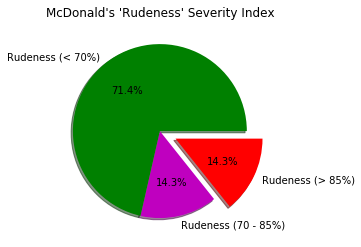

In [87]:
values = list(dict_severity.values())
colors = ['r', 'm','g', ]
labels = list(dict_severity.keys())
explode = (0.2, 0, 0)
plt.pie(values, colors=colors, labels=labels,
explode=explode, autopct='%1.1f%%',
counterclock=False, shadow=True)
plt.title("McDonald's 'Rudeness' Severity Index")
plt.show()